## Chapter 8 - Problem 10
***

**10.** We now use boosting to predict *Salary* in the *Hitters* data set.

**A.** Remove the observations for whom the salary information is
unknown, and then log-transform the salaries.

In [1]:
require(ISLR)
summary(Hitters)
sum(is.na(Hitters))

Loading required package: ISLR


     AtBat            Hits         HmRun            Runs       
 Min.   : 16.0   Min.   :  1   Min.   : 0.00   Min.   :  0.00  
 1st Qu.:255.2   1st Qu.: 64   1st Qu.: 4.00   1st Qu.: 30.25  
 Median :379.5   Median : 96   Median : 8.00   Median : 48.00  
 Mean   :380.9   Mean   :101   Mean   :10.77   Mean   : 50.91  
 3rd Qu.:512.0   3rd Qu.:137   3rd Qu.:16.00   3rd Qu.: 69.00  
 Max.   :687.0   Max.   :238   Max.   :40.00   Max.   :130.00  
                                                               
      RBI             Walks            Years            CAtBat       
 Min.   :  0.00   Min.   :  0.00   Min.   : 1.000   Min.   :   19.0  
 1st Qu.: 28.00   1st Qu.: 22.00   1st Qu.: 4.000   1st Qu.:  816.8  
 Median : 44.00   Median : 35.00   Median : 6.000   Median : 1928.0  
 Mean   : 48.03   Mean   : 38.74   Mean   : 7.444   Mean   : 2648.7  
 3rd Qu.: 64.75   3rd Qu.: 53.00   3rd Qu.:11.000   3rd Qu.: 3924.2  
 Max.   :121.00   Max.   :105.00   Max.   :24.000   Max.   :14053.0 

[1] 59

In [4]:
Hitters <- na.omit(Hitters)
sum(is.na(Hitters))

[1] 0

In [5]:
Hitters$logSalary <- log(Hitters$Salary)

**B.** Create a training set consisting of the first 200 observations, and
a test set consisting of the remaining observations.

In [6]:
set.seed(6872)
train <- sample(1:nrow(Hitters),200)
Hitters.train <- Hitters[train,]
Hitters.test <- Hitters[-train,]

**C.** Perform boosting on the training set with 1,000 trees for a range
of values of the shrinkage parameter λ. Produce a plot with
different shrinkage values on the x-axis and the corresponding
training set MSE on the y-axis.

In [57]:
require(gbm)
power <- seq(from = -5, to = 0,by = 0.1)
nshrink <- 10^power

train.mse <- rep(NA,length(power))

for (i in 1:length(nshrink)){
    Hitters.boosting <- gbm(logSalary~.-Salary,data = Hitters.train, distribution = "gaussian", 
                            n.trees = 1000,shrinkage = nshrink[i])
    train.mse[i] <- Hitters.boosting$train.error[1000]
}



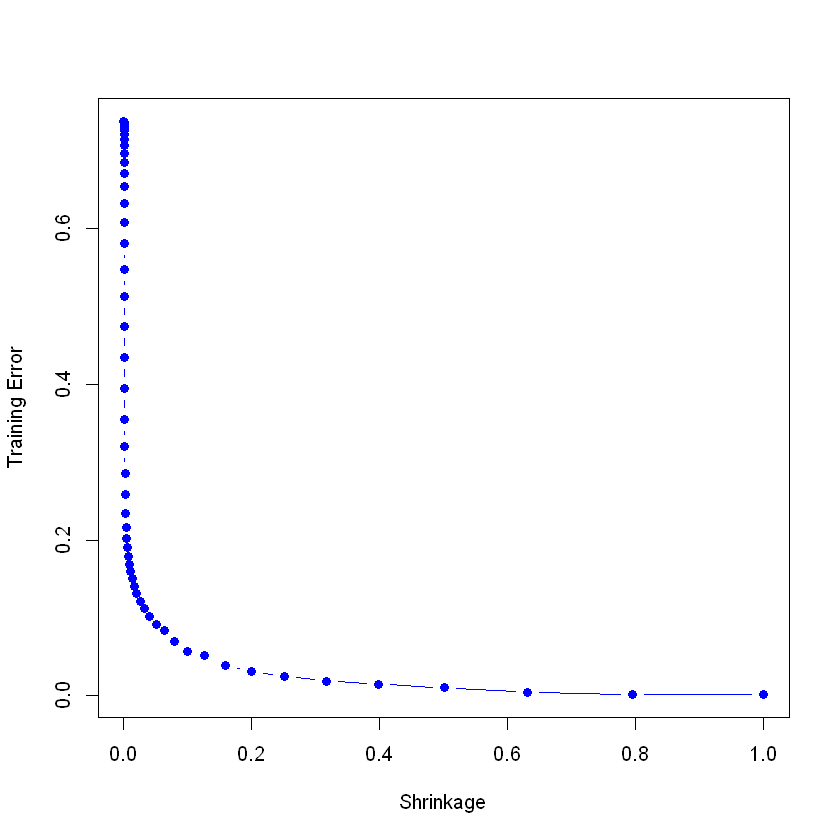

In [58]:
plot(nshrink,train.mse, col = "blue", pch = 19, type = "b", xlab = "Shrinkage", ylab = "Training Error")

Lower shrinkage error produce more training error. This is because low shrinkage values require more trees to give better performance.

**D.** Produce a plot with different shrinkage values on the x-axis and
the corresponding test set MSE on the y-axis.

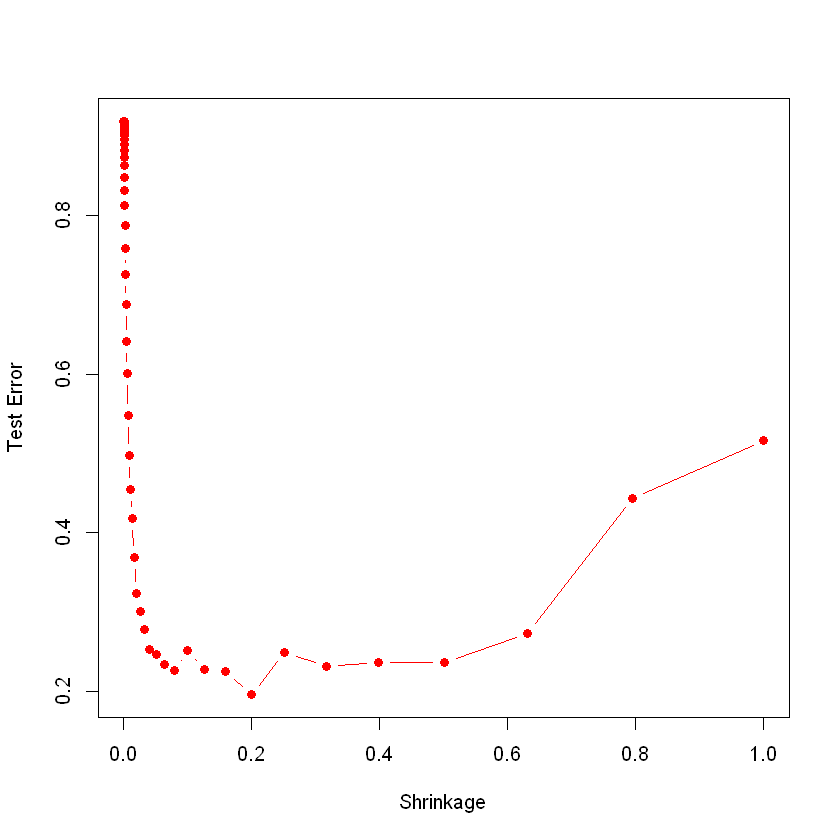

In [59]:
hitters.pred <- rep(NA,nrow(Hitters.test))
test.mse <- rep(NA,length(power))

for (i in 1:length(nshrink)){
    Hitters.boosting <- gbm(logSalary~.-Salary,data = Hitters.train, distribution = "gaussian", 
                            n.trees = 1000,shrinkage = nshrink[i])
    hitters.pred <- predict(Hitters.boosting,newdata = Hitters.test,n.trees = 100)
    test.mse[i] <- mean((hitters.pred-Hitters.test$logSalary)^2) 
}

plot(nshrink,test.mse, col = "red", pch = 19, type = "b", xlab = "Shrinkage", ylab = "Test Error")

In [69]:
min(test.mse)

[1] 0.1957444

In [61]:
nshrink[which.min(test.mse)]

[1] 0.1995262

at $\lambda = 0.2$ the minimum test error was attained.

**E.** Compare the test MSE of boosting to the test MSE that results from applying two of the regression approaches seen in
Chapters 3 and 6.

## Linear Regression

In [67]:
hitters.linear <- lm(logSalary~.-Salary, data = Hitters.train)
hitters.linear.pred <- predict(hitters.linear, newdata = Hitters.test, type = "response")
test.mse.linear <- mean((hitters.linear.pred - Hitters.test$logSalary)^2)
test.mse.linear

[1] 0.4541308

## Ridge Regression

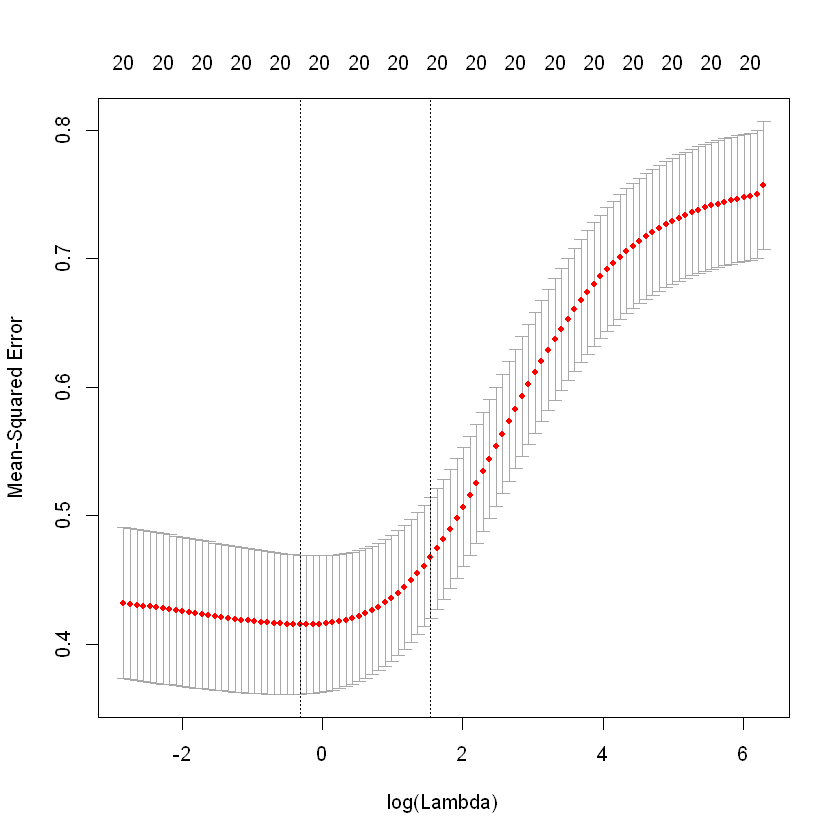

In [80]:
library(glmnet)

x <- model.matrix(logSalary~.-1-Salary,data = Hitters.train) #Eliminates intercept
y <- Hitters.train$logSalary

cv.ridge <- cv.glmnet(x,y,alpha = 0)
plot(cv.ridge)

In [103]:
ridge.tr <- glmnet(x,y,alpha = 0,nlambda = 10)

x.test <- model.matrix(logSalary~.-1-Salary,data = Hitters.test)
y.test <- Hitters.test$logSalary

ridge.pred <- predict(ridge.tr,newx = x.test)
ridge.mse <- mean((ridge.pred-y.test)^2)

In [104]:
ridge.mse

[1] 0.6479421

Both Ridge Regression and Linear Model have a higher test MSE than the boosting method.

**F.** Which variables appear to be the most important predictors in
the boosted model?

,var,rel.inf
CAtBat,CAtBat,12.4847053
CWalks,CWalks,9.7817654
CHmRun,CHmRun,8.3781052
PutOuts,PutOuts,8.3545115
CRuns,CRuns,8.2302507
Walks,Walks,7.6749070
Assists,Assists,6.2481290
Runs,Runs,6.0978940
AtBat,AtBat,5.6016416
Hits,Hits,5.2424259


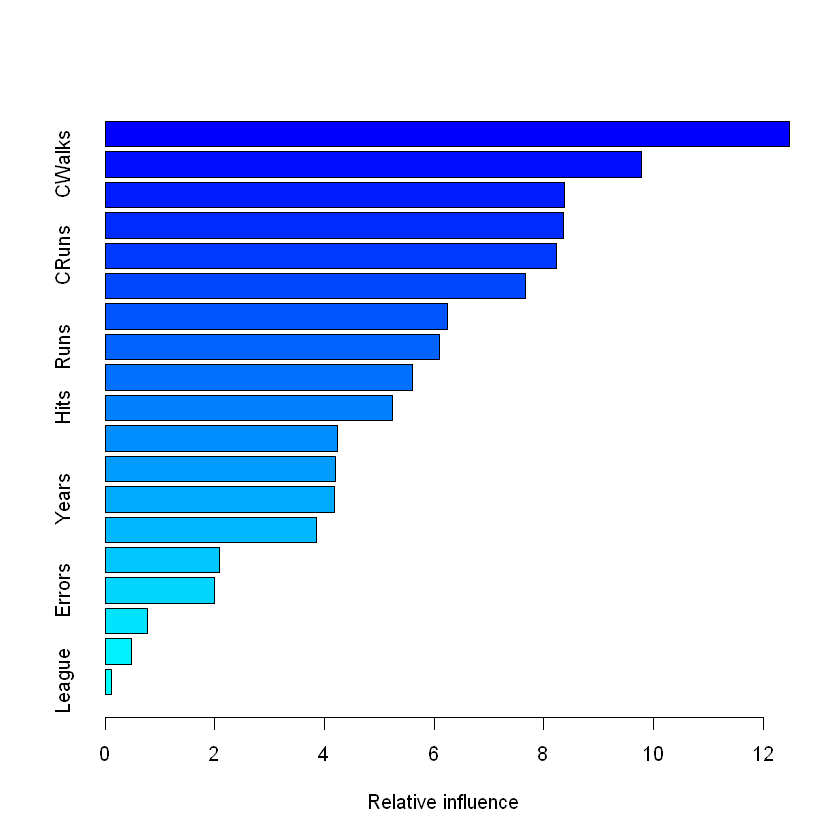

In [107]:
Hitters.boosting <- gbm(logSalary~.-Salary,data = Hitters.train, distribution = "gaussian", 
                            n.trees = 1000,shrinkage = 0.2)
summary(Hitters.boosting)

According to the boosting method. The most important variables on the salary are: <br>
**CAtBat**: number of times at bat during his career. <br>
**CWalks**: number of walks during his career. <br>
**CHmRun**: number of Home runs during his career. <br>
**PutOuts**: Number of put outs. <br>

**G.** Now apply bagging to the training set. What is the test set MSE
for this approach?

In [116]:
Hitters.bagging <- randomForest(logSalary~.-Salary,data = Hitters.train, 
                                mtry = ncol(Hitters.train)-2, ntree = 500)
Hitters.pred <- predict(Hitters.bagging,newdata = Hitters.test)
bagging.test.error <- with(Hitters.test,mean((logSalary-Hitters.pred)^2)) 

In [117]:
bagging.test.error 

[1] 0.237998

The bagging test error is slighlty higher than the test error obtained from the boosting error. However it is still lower than both the test error obtained from the linear and the ridge regression models.